## Initial analysis

In [239]:
# Install the required libraries (from pip_requirements.txt)
%pip install -r pip_requirements.txt

!python -m spacy download en_core_web_sm

Note: you may need to restart the kernel to use updated packages.
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ----- ---------------------------------- 1.8/12.8 MB 10.0 MB/s eta 0:00:02
     --------------- ------------------------ 5.0/12.8 MB 12.1 MB/s eta 0:00:01
     -------------------------- ------------- 8.4/12.8 MB 13.3 MB/s eta 0:00:01
     ----------------------------------- --- 11.5/12.8 MB 13.6 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 12.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [240]:
# Modules to import
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
from importlib import reload

In [241]:
paths = ['src/data','src/models','src/scripts','src/utils']
for path in paths:
    sys.path.append(path)

## I. Data preprocessing

### I.1 Original data

In [242]:
# Execute dataCleaning.py
# This script create dictionaries of freebase_id, convert date to datetime object, transform our columns

%run src/scripts/dataCleaning.py

Movies successfully loaded
Characters successfully loaded
Clusters successfully loaded
Summaries successfully loaded
Dates successfully converted
Build of countries dictionnary...
Build of languages dictionnary...
Build of genres dictionnary...
Build of actors dictionnary...
Build of character dictionnary...
Build of movies dictionnary...
Dictionnaries successfully saved
Saved movies_cleaned to data/cleanData/movies_cleaned.csv
Saved characters_cleaned to data/cleanData/characters_cleaned.csv
Saved character_clusters_cleaned to data/cleanData/character_clusters_cleaned.csv
Saved summaries_cleaned to data/cleanData/summaries_cleaned.csv
Datasets successfully saved
Data cleaning successfully done


Load the data

In [243]:
# Import dataloader function
from dataLoader import loadDataframe

In [244]:
# Load data
path_to_directory = 'data/cleanData/'
df_movies = loadDataframe('movies', path_to_directory)

c:\Users\aurel\ADA_project_2024\ada-2024-project-teamcsx24\src/data\dataLoader.py:10: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



### I.2 Additional data

#### I.2.1 Additional movie dataset from Kaggle

Because the revenue is important for the Economics part of our analysis we try to add a new dataset from Kaggle with movies to add more consistency to our results.

The new dataset has the revenue and the budget as interesting features for the Economics analysis.

In [245]:
#Execute additionaldataCleaning.py
#This script create dictionaries of freebase_id, convert date to datetime object, transform our columns TO CHANGE

%run src/scripts/additionaldataCleaning.py

Additional Movies successfully loaded
Monthly inflation data successfully loaded
Budget successfully converted
Filtered additional movie data successfully created
Inflation data successfully processed
Saved Kaggle_US_CPI_monthly_cleaned to data/cleanData/Kaggle_US_CPI_monthly_cleaned.csv
Saved monthly inflation data to Kaggle_US_CPI_monthly_cleaned.csv
Saved Kaggle_US_CPI_annual_cleaned to data/cleanData/Kaggle_US_CPI_annual_cleaned.csv
Saved annual inflation data to Kaggle_US_CPI_annual_cleaned.csv
Saved Kaggle_movie_data_tmdb_cleaned to data/cleanData/Kaggle_movie_data_tmdb_cleaned.csv
Saved additional movie data to Kaggle_movie_data_tmdb_cleaned.csv
Saved Kaggle_movie_data_tmdb_filtered_cleaned to data/cleanData/Kaggle_movie_data_tmdb_filtered_cleaned.csv
Saved filtered additional movie data to Kaggle_movie_data_tmdb_filtered_cleaned.csv


Data statistics overview

In [246]:
from dataLoader import loadAdditionalDataframe

In [247]:
df_inflation_additional_annual = loadAdditionalDataframe('inflation_annual', path_to_directory)
df_inflation_additional_monthly = loadAdditionalDataframe('inflation_monthly', path_to_directory)  
df_movies_additional = loadAdditionalDataframe('movies_additional', path_to_directory)
df_movies_additional_filtered = loadAdditionalDataframe('movies_additional_filtered', path_to_directory)

In [248]:
df_movies_additional.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119931 entries, 0 to 119930
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   imdb_id            114475 non-null  object 
 1   original_title     119392 non-null  object 
 2   original_language  119392 non-null  object 
 3   budget             119074 non-null  float64
 4   revenue            119071 non-null  object 
 5   release_date       118642 non-null  object 
 6   title              118752 non-null  object 
dtypes: float64(1), object(6)
memory usage: 6.4+ MB


In [249]:
# Non null values proportion
df_movies_additional.isnull().mean()

imdb_id              0.045493
original_title       0.004494
original_language    0.004494
budget               0.007146
revenue              0.007171
release_date         0.010748
title                0.009831
dtype: float64

The features that we are interested in are the following:
- 'original_title' : more than 99% of the movies have a title
- 'revenue' : more than 99% of the movies have a revenue
- 'budget' : more than 99% of the movies have a budget

So we have a large amount of non null values that we can use to make our economics analysis.

In [250]:
from generalUtils import intersectionId

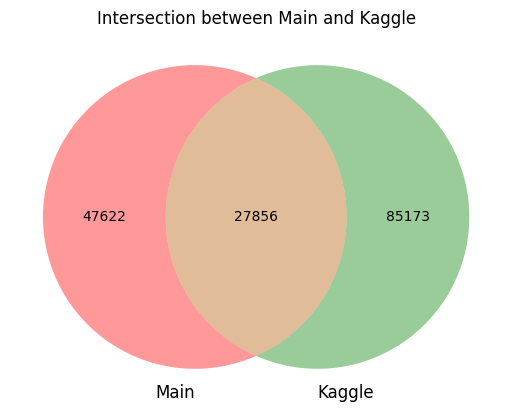

In [251]:
intersectionId(df_movies, df_movies_additional, 'Main', 'Kaggle', id_column='original_title')

More than 27,000 movies from the original database are intersected with the Kaggle dataset choosing the original_title as a common key.

In [252]:
df_movies_additional.loc[df_movies_additional['budget'] != 0].count()

imdb_id              14391
original_title       14504
original_language    14504
budget               14186
revenue              14496
release_date         14431
title                14178
dtype: int64

However, after a deeper analysis on the Kaggle dataset we realize that only ~14,000 values are not null for the budget and the revenue. So, a lot of implicit missing values were hidden in the Kaggle dataset.

Additional movie data from Kaggle where budget is not null

In [253]:
df_movies_additional_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15043 entries, 0 to 15042
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   imdb_id            14391 non-null  object 
 1   original_title     14504 non-null  object 
 2   original_language  14504 non-null  object 
 3   budget             14186 non-null  float64
 4   revenue            14496 non-null  object 
 5   release_date       14431 non-null  object 
 6   title              14178 non-null  object 
dtypes: float64(1), object(6)
memory usage: 822.8+ KB


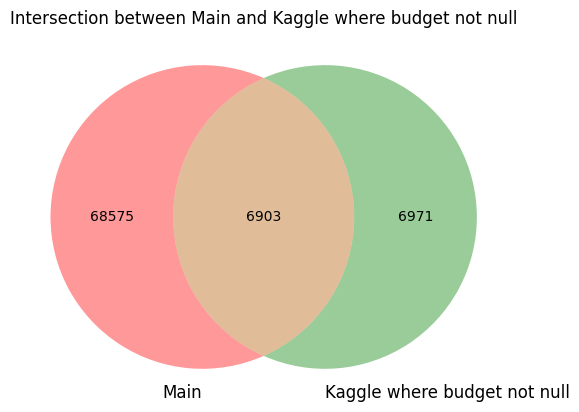

In [254]:
intersectionId(df_movies, df_movies_additional_filtered, 'Main', 'Kaggle where budget not null', id_column='original_title')

Finally, we realize that only 6,903 movies from the original database are intersected with the Kaggle dataset choosing the original_title as a common key.

This is much lower than we had hoped, which makes the dataset irrelevant in our case, as the feature revenue of the original dataset had 8401 non-zero values.

### I.2.2 Inflation dataset from Kaggle

Because we are going to study the revenue of movies it is also important to consider the Inflation by importing a dataset from Kaggle. Without adjusting for inflation, raw revenue data can be misleading, underestimating or overestimating the relative success of films from past eras. Adjusting for inflation makes analyses much more relevant and nuanced for understanding the evolution of the film industry. We make the assumption that the Consumer Price Index of the USA is representative of the rest of the world.

In [255]:
df_inflation_additional_monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Yearmon  1296 non-null   datetime64[ns]
 1   CPI      1296 non-null   float64       
 2   year     1296 non-null   int32         
dtypes: datetime64[ns](1), float64(1), int32(1)
memory usage: 25.4 KB


In [256]:
df_inflation_additional_annual.describe()

,year,CPI
count,108.00000,108.000000
mean,1966.50000,81.641431
std,31.32092,79.760606
min,1913.00000,9.883333
25%,1939.75000,17.495833
50%,1966.50000,32.908333
75%,1993.25000,145.400000
max,2020.00000,258.811167


The annual inflation dataset from 1913 to 2020 will be used to readjust the revenue of movies considering the year of release.

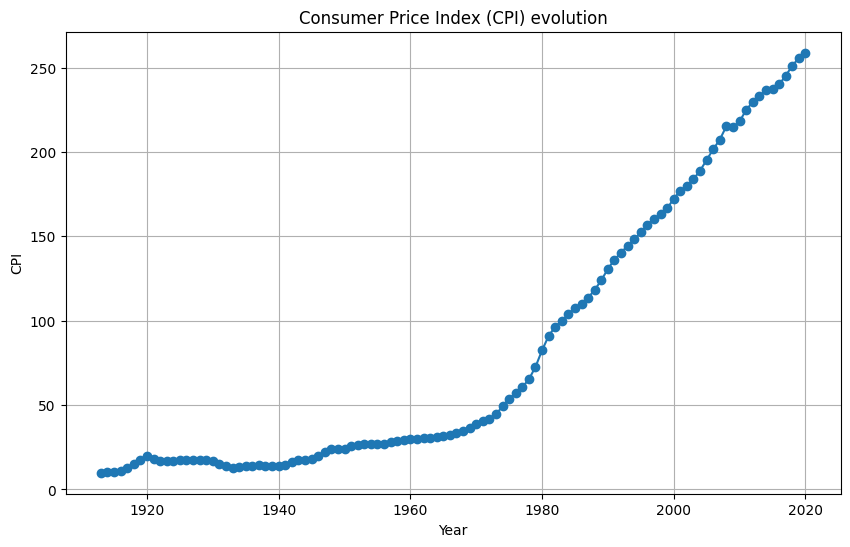

In [257]:
# plot the temporal evolution of the Consumer Price Index (CPI)
plt.figure(figsize=(10, 6))
plt.plot(df_inflation_additional_annual['year'], df_inflation_additional_annual['CPI'], marker='o')
plt.title('Consumer Price Index (CPI) evolution')
plt.xlabel('Year')
plt.ylabel('CPI')
plt.grid()
plt.show()


## III. Economics

### III.1 Dataframe for Economics part

Filtering on notna box office revenue

In [258]:
df_movies_eco = df_movies[df_movies['revenue'].notna()]
df_movies_eco['year'] = df_movies_eco['release_date'].dt.year
df_movies_eco.describe()

C:\Users\aurel\AppData\Local\Temp\ipykernel_3116\306766949.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,wiki_id,release_date,revenue,runtime,year
count,8.401000e+03,8328,8.401000e+03,8302.000000,8328.000000
mean,9.138449e+06,1991-06-28 21:27:39.942363136,4.799363e+07,105.579583,1991.056076
min,3.217000e+03,1897-05-22 00:00:00,1.000000e+04,10.000000,1897.000000
25%,1.231856e+06,1984-12-29 06:00:00,2.083193e+06,93.000000,1984.750000
50%,4.143564e+06,1997-09-06 00:00:00,1.063969e+07,102.000000,1997.000000
75%,1.521043e+07,2006-06-23 00:00:00,4.071696e+07,114.000000,2006.000000
max,3.706127e+07,2012-10-25 00:00:00,2.782275e+09,1003.000000,2012.000000
std,1.025119e+07,NaN,1.121753e+08,23.503176,19.728927


To carry out our study we will be able to rely on 8401 non-zero income values.

Recalculating box office revenue indexed to US inflation

<Axes: xlabel='year'>

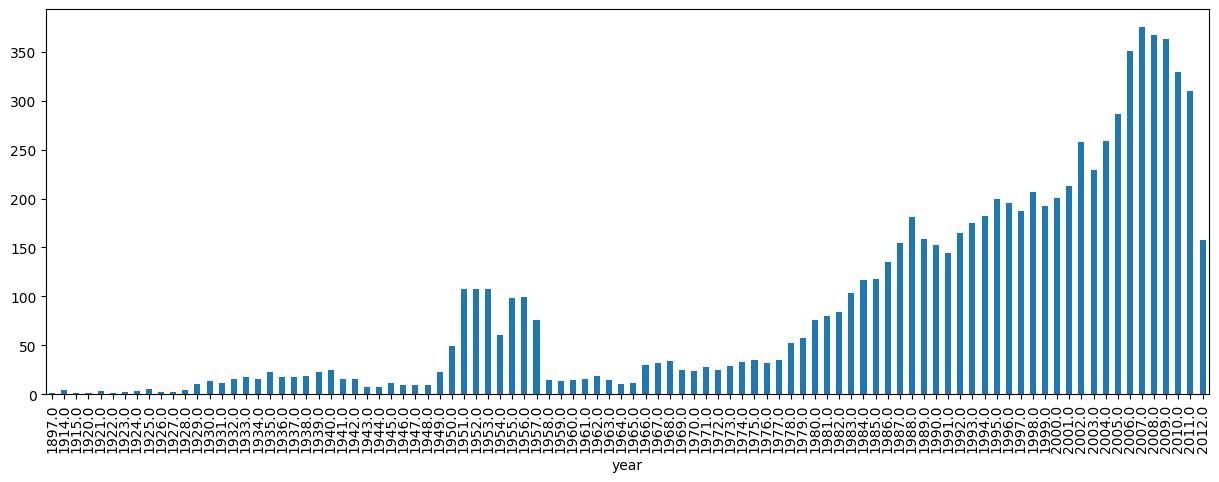

In [259]:
df_movies_eco['year'].value_counts().sort_index().plot(kind='bar', figsize=(15, 5))

Income values in the orignal dataset range from 1897 to 2012 with only one value in 1897. So, considering the CPI dataset ranges from 1914 to 2020, we remove the first revenue value and null values.

In [260]:
df_movies_eco = df_movies_eco.dropna(subset=['year'])
df_movies_eco = df_movies_eco[df_movies_eco['year'] != 1897]
df_movies_eco['revenue'].notnull().sum()


np.int64(8327)

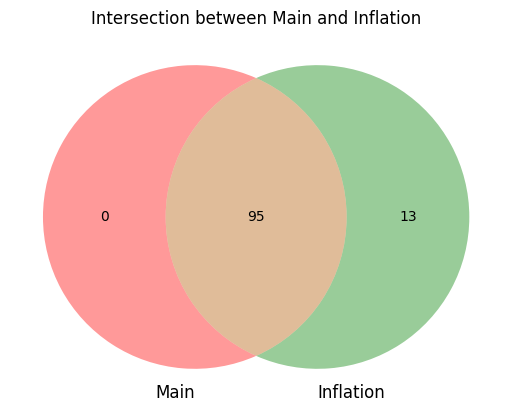

In [261]:
intersectionId(df_movies_eco, df_inflation_additional_annual, 'Main', 'Inflation', id_column='year')

Finally, the Economic analysis is conducted on a sample of 8327 movies. We notice that all the years of the selected sample of 8327 movies have a correspondance in the inflation dataset. So, we are able to calculate the income reindexed for inflation, using the midpoint year between 2012 and 1914 as a reference year (1963 in this case) to minimize edge effects.








In [262]:
reference_year = 1963
cpi_reference = df_inflation_additional_annual[df_inflation_additional_annual['year'] == reference_year]['CPI'].values[0]
df_movies_eco['revenue_adj'] = df_movies_eco.apply(lambda x: x['revenue'] * cpi_reference / df_inflation_additional_annual[df_inflation_additional_annual['year'] == x['year']]['CPI'].values[0], axis=1)

In [263]:
df_movies_eco.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8327 entries, 0 to 81732
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   wiki_id                8327 non-null   int64         
 1   freebase_id            8327 non-null   object        
 2   original_title         8327 non-null   object        
 3   release_date           8327 non-null   datetime64[ns]
 4   revenue                8327 non-null   float64       
 5   runtime                8243 non-null   float64       
 6   languages              8327 non-null   object        
 7   countries              8327 non-null   object        
 8   genres                 8327 non-null   object        
 9   countries_freebase_id  8327 non-null   object        
 10  languages_freebase_id  8327 non-null   object        
 11  genres_freebase_id     8327 non-null   object        
 12  year                   8327 non-null   float64       
 13  revenue

### III.2 Free exchange of goods and services

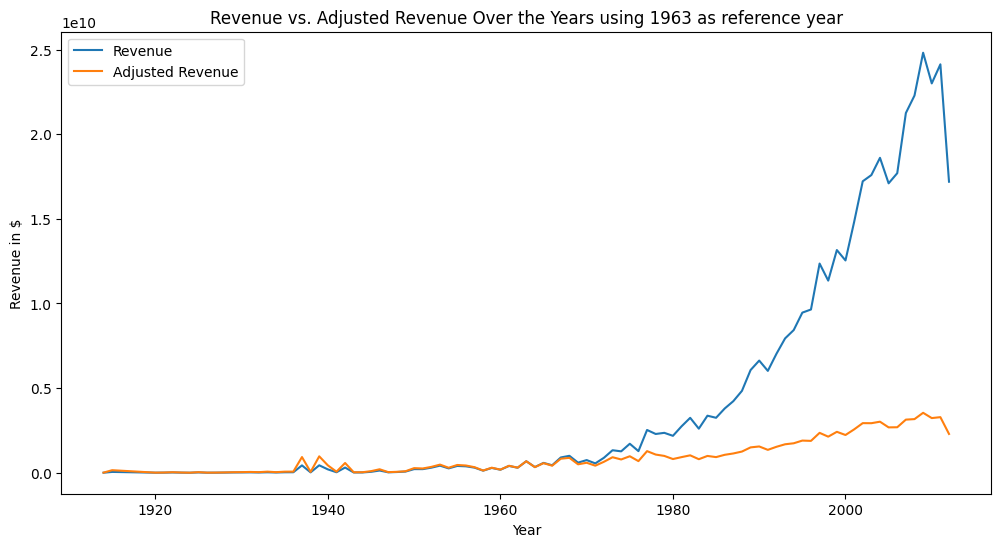

In [264]:
# plot the revenue vs. adjusted revenue over the years
plt.figure(figsize=(12, 6))
plt.plot(df_movies_eco.groupby('year')['revenue'].sum(), label='Revenue')
plt.plot(df_movies_eco.groupby('year')['revenue_adj'].sum(), label='Adjusted Revenue')
plt.xlabel('Year')
plt.ylabel('Revenue in $')
plt.title('Revenue vs. Adjusted Revenue Over the Years using 1963 as reference year')
plt.legend()


From the previous plot we observe that the computation of the value of revenue adjusted for inflation is an essential indicator for correctly interpreting the evolution of film revenues over a long period, in the context of the film industry from 1914 to 2012. we can confirm that using 1963 as the reference year helps to minimize potential edge effects that might have appeared if a more recent or much older year were used.

Observations:

   - The orange line remains relatively flat, suggesting that when adjusted to 1963 dollars, the revenue of movies has not significantly increased over time. This could imply that the apparent increase in revenue is primarily due to inflation rather than a true increase in movie profitability.
    
   - The blue line rises especially from the 1980s, reflecting an increase in nominal revenue, likely driven by more films produced higher ticket prices, broader audiences, and expanding international markets.

Finally, we can state that it is possible to address the topic of free trade in goods and services, by examining the box office revenue of films over time and potentially by splitting by country.

In [265]:
def transformCountryNameGpd(countries_freebase_id):
    # Load countries dictionnary
    with open('././data/freebaseIdDictionnaries/countries_geo', 'r') as file:
        countries_dict = json.load(file)
    
    # Transform countries names to geopandas names using the freebase id
    countries_name = []
    n = len(countries_freebase_id)
    for i in range(n):
        country_freebase_id = countries_freebase_id[i]
        country_name = countries_dict[country_freebase_id]
        countries_name.append(country_name)
    
    return countries_name

In [266]:
df_movies_eco['countries'] = df_movies_eco['countries_freebase_id'].apply(transformCountryNameGpd)


In [267]:
df_movies_eco[df_movies_eco['countries'].apply(lambda x: len(x) == 0)].count()

wiki_id                  99
freebase_id              99
original_title           99
release_date             99
revenue                  99
runtime                  75
languages                99
countries                99
genres                   99
countries_freebase_id    99
languages_freebase_id    99
genres_freebase_id       99
year                     99
revenue_adj              99
dtype: int64

In [268]:
#we create duplicates of the rows with multiple production countries
df_movies_eco_exploded_countries = df_movies_eco.explode('countries')

In [277]:
df_movies_eco_exploded_countries[df_movies_eco_exploded_countries['countries'] == 'nan'].count()

wiki_id                  99
freebase_id              99
original_title           99
release_date             99
revenue                  99
runtime                  75
languages                99
countries                99
genres                   99
countries_freebase_id    99
languages_freebase_id    99
genres_freebase_id       99
year                     99
revenue_adj              99
dtype: int64

In [278]:
df_movies_eco_exploded_countries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11084 entries, 0 to 81732
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   wiki_id                11084 non-null  int64         
 1   freebase_id            11084 non-null  object        
 2   original_title         11084 non-null  object        
 3   release_date           11084 non-null  datetime64[ns]
 4   revenue                11084 non-null  float64       
 5   runtime                10993 non-null  float64       
 6   languages              11084 non-null  object        
 7   countries              11084 non-null  object        
 8   genres                 11084 non-null  object        
 9   countries_freebase_id  11084 non-null  object        
 10  languages_freebase_id  11084 non-null  object        
 11  genres_freebase_id     11084 non-null  object        
 12  year                   11084 non-null  float64       
 13  revenu

In [279]:
df_movies_eco_exploded_countries = df_movies_eco_exploded_countries[df_movies_eco_exploded_countries['countries'] != 'nan']

In [280]:
df_movies_eco_exploded_countries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10985 entries, 0 to 81726
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   wiki_id                10985 non-null  int64         
 1   freebase_id            10985 non-null  object        
 2   original_title         10985 non-null  object        
 3   release_date           10985 non-null  datetime64[ns]
 4   revenue                10985 non-null  float64       
 5   runtime                10918 non-null  float64       
 6   languages              10985 non-null  object        
 7   countries              10985 non-null  object        
 8   genres                 10985 non-null  object        
 9   countries_freebase_id  10985 non-null  object        
 10  languages_freebase_id  10985 non-null  object        
 11  genres_freebase_id     10985 non-null  object        
 12  year                   10985 non-null  float64       
 13  revenu

In [281]:
df_movies_eco_exploded_countries[df_movies_eco_exploded_countries['countries'] == 'nan'].count()

wiki_id                  0
freebase_id              0
original_title           0
release_date             0
revenue                  0
runtime                  0
languages                0
countries                0
genres                   0
countries_freebase_id    0
languages_freebase_id    0
genres_freebase_id       0
year                     0
revenue_adj              0
dtype: int64

First try to split by country with a specific one

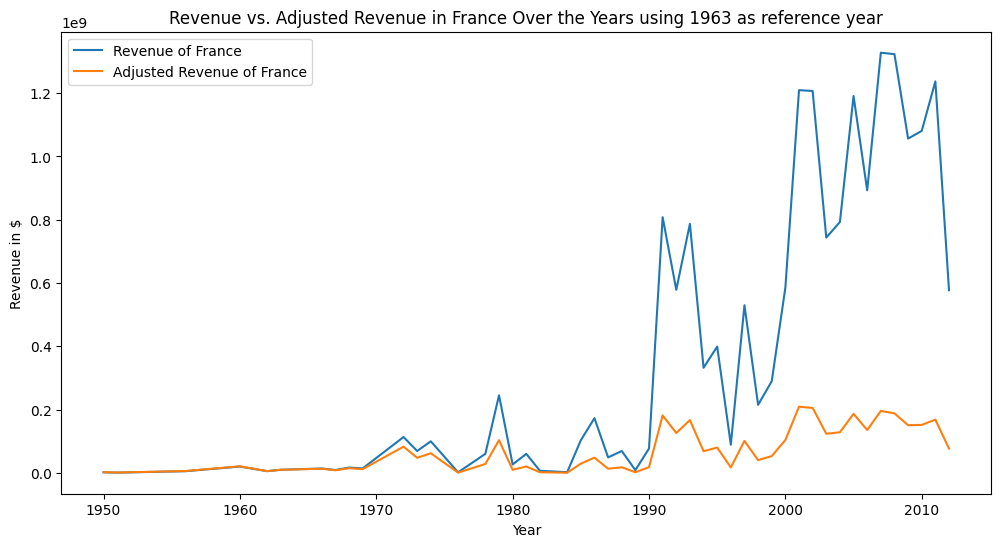

In [271]:
# plot the revenue vs. adjusted revenue over the years
plt.figure(figsize=(12, 6))
plt.plot(df_movies_eco_exploded_countries[df_movies_eco_exploded_countries.countries == 'France'].groupby('year')['revenue'].sum(), label='Revenue of France')
plt.plot(df_movies_eco_exploded_countries[df_movies_eco_exploded_countries.countries == 'France'].groupby('year')['revenue_adj'].sum(), label='Adjusted Revenue of France')
plt.xlabel('Year')
plt.ylabel('Revenue in $')
plt.title('Revenue vs. Adjusted Revenue in France Over the Years using 1963 as reference year')
plt.legend()

Let's create an interactive plot to select the country

In [272]:
def plot_revenue_vs_adjusted_revenue(data, country):
    plt.figure(figsize=(12, 6))
    plt.plot(df_movies_eco_exploded_countries[df_movies_eco_exploded_countries.countries == country].groupby('year')['revenue'].sum(), label=f'Revenue of {country}')
    plt.plot(df_movies_eco_exploded_countries[df_movies_eco_exploded_countries.countries == country].groupby('year')['revenue_adj'].sum(), label=f'Adjusted Revenue of {country}')
    plt.xlabel('Year')
    plt.ylabel('Revenue in $')
    plt.title(f'Revenue vs. Adjusted Revenue in {country} Over the Years using 1963 as reference year')
    plt.legend()

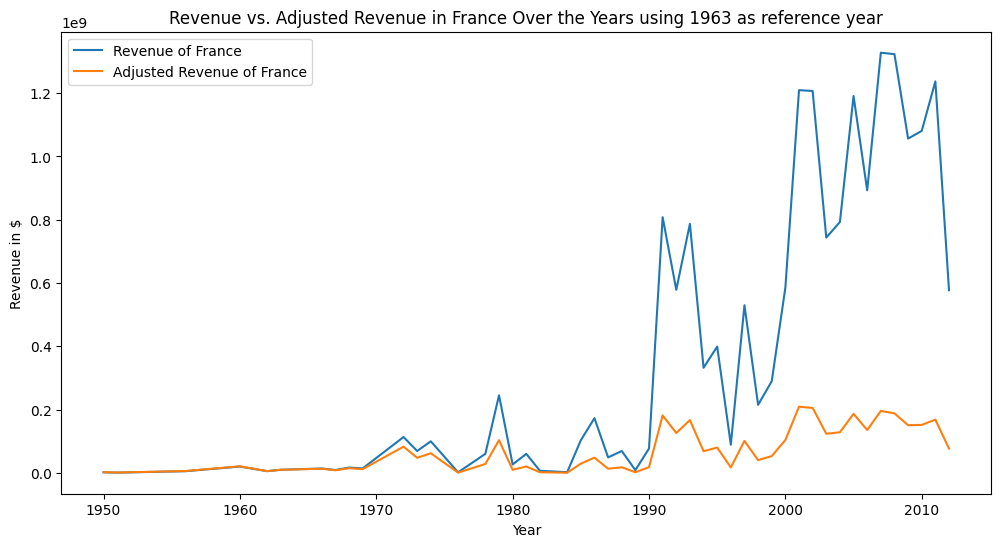

In [126]:
plot_revenue_vs_adjusted_revenue(df_movies_eco_exploded_countries, 'France')

In [273]:
import plotly.graph_objects as go

def interactive_revenue_plot(data):
    # Initialize figure
    fig = go.Figure()
    data['countries'] = data['countries'].astype(str)
    # Add traces for each country's data
    for country in data['countries'].unique():
        country_data = data[data['countries'] == country].groupby('year', as_index = False)[['revenue','revenue_adj']].sum()
        
        # Add Revenue trace
        fig.add_trace(go.Scatter(
            x=country_data['year'],
            y=country_data['revenue'],
            mode='lines',
            name=f'Revenue ({country})',
            visible=True if country == data['countries'].unique()[0] else False
        ))

        # Add Adjusted Revenue trace
        fig.add_trace(go.Scatter(
            x=country_data['year'],
            y=country_data['revenue_adj'],
            mode='lines',
            name=f'Adjusted Revenue ({country})',
            visible=True if country == data['countries'].unique()[0] else False
        ))

    # Create dropdown buttons for filtering by country
    buttons = []
    for country in data['countries'].unique():
         # Ensure trace names are strings for comparison
        visibility = [country in str(trace.name) for trace in fig.data]
        
        button = {
            'label': country,
            'method': 'update',
            'args': [
                {'visible': visibility},
                {'title': f"Revenue vs Adjusted Revenue: {country}"}
            ]
        }
        buttons.append(button)

    # Update layout with dropdown menu
    fig.update_layout(
        updatemenus=[{
            'buttons': buttons,
            'direction': 'down',
            'showactive': True,
        }],
        title="Revenue vs Adjusted Revenue Over the Years",
        xaxis_title='Year',
        yaxis_title='Revenue in $',
    )

    # Show the figure
    fig.show()

# Example Usage:
# Assuming `df` is a DataFrame with columns ['Year', 'Country', 'Revenue']
# df = pd.DataFrame({...})
# interactive_revenue_plot(df)


In [114]:
pip install --upgrade nbformat

Note: you may need to restart the kernel to use updated packages.


In [274]:
interactive_revenue_plot(df_movies_eco_exploded_countries)

In [306]:
import plotly.graph_objects as go

def interactive_revenue_plot_country(data):
    # Initialize figure
    fig = go.Figure()
    data['countries'] = data['countries'].astype(str)

    # Define colors for consistent styling
    colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880']

    # Add traces for each country's data
    for i, country in enumerate(data['countries'].unique()):
        country_data = data[data['countries'] == country].groupby('year', as_index=False)[['revenue', 'revenue_adj']].sum()

        # Assign colors dynamically
        color = colors[i % len(colors)]

        # Add Revenue trace
        fig.add_trace(go.Scatter(
            x=country_data['year'],
            y=country_data['revenue'],
            mode='lines+markers',
            name=f'Revenue ({country})',
            visible=True if country == data['countries'].unique()[0] else False,
            line=dict(width=2),
            marker=dict(size=6, symbol='circle'),
            yaxis='y'  # Use the primary y-axis
        ))

        # Add Adjusted Revenue trace
        fig.add_trace(go.Scatter(
            x=country_data['year'],
            y=country_data['revenue_adj'],
            mode='lines+markers',
            name=f'Adjusted Revenue ({country})',
            visible=True if country == data['countries'].unique()[0] else False,
            line=dict(width=2),
            marker=dict(size=6, symbol='square'),
            yaxis='y2'  # Use the secondary y-axis
        ))

    # Create dropdown buttons for filtering by country
    buttons = []
    for country in data['countries'].unique():
        visibility = [country == trace.name.split('(')[1].split(')')[0].strip() for trace in fig.data]

        button = {
            'label': country,
            'method': 'update',
            'args': [
                {'visible': visibility},  # Update visibility of traces
                {'title': f"Revenue vs Adjusted Revenue: {country}"}
            ]
        }
        buttons.append(button)

    # Update layout with dropdown menu and styling
    fig.update_layout(
        updatemenus=[{
            'buttons': buttons,
            'direction': 'down',
            'showactive': True,
            'x': 0.5,
            'y': 1.15,
            'xanchor': 'center',
            'yanchor': 'top'
        }],
        title={
            'text': "Revenue vs Adjusted Revenue Over the Years",
            'y': 0.95,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(size=20, family='Arial, sans-serif')
        },
        xaxis=dict(
            title='Year',
            titlefont=dict(size=16),
            tickfont=dict(size=12),
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=False
        ),
        yaxis=dict(
            title='Revenue',
            titlefont=dict(size=16),
            tickfont=dict(size=12),
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=False
        ),
        yaxis2=dict(
            title='Adjusted Revenue',
            titlefont=dict(size=16),
            tickfont=dict(size=12),
            overlaying='y',
            side='right',
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=False
        ),
        legend=dict(
            title='Legend',
            x=0.01,
            y=0.99,
            bordercolor="Black",
            borderwidth=1,
            font=dict(size=12)
        ),
        plot_bgcolor='white'
    )

    # Add grid lines and background
    fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
    fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)

    # Show the figure
    fig.show()


In [307]:
interactive_revenue_plot_country(df_movies_eco_exploded_countries)

Let's create an interactive plot to select regions

In [284]:
def attachWorldRegion(country):
    # Load countries dictionnary
    with open('././data/freebaseIdDictionnaries/regions', 'r') as file:
        countries_regions = json.load(file)
    
    # Convert country to string
    country = str(country)
    
    # Attach a world region to each country
    world_region = countries_regions[country]
    
    return world_region

In [ ]:
df_movies_eco_exploded_countries['region'] = df_movies_eco_exploded_countries['countries'].apply(attachWorldRegion)

In [304]:
import plotly.graph_objects as go

def interactive_revenue_plot_region(data):
    # Initialize figure
    fig = go.Figure()
    data['region'] = data['region'].astype(str)

    # Define colors for consistent styling
    colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880']

    # Add traces for each region's data
    for i, region in enumerate(data['region'].unique()):
        region_data = data[data['region'] == region].groupby('year', as_index=False)[['revenue', 'revenue_adj']].sum()

        # Assign colors dynamically
        color = colors[i % len(colors)]

        # Add Revenue trace
        fig.add_trace(go.Scatter(
            x=region_data['year'],
            y=region_data['revenue'],
            mode='lines+markers',
            name=f'Revenue ({region})',
            visible=True if region == data['region'].unique()[0] else False,
            line=dict(width=2),
            marker=dict(size=6, symbol='circle'),
            yaxis='y'  # Use the primary y-axis
        ))

        # Add Adjusted Revenue trace
        fig.add_trace(go.Scatter(
            x=region_data['year'],
            y=region_data['revenue_adj'],
            mode='lines+markers',
            name=f'Adjusted Revenue ({region})',
            visible=True if region == data['region'].unique()[0] else False,
            line=dict(width=2),
            marker=dict(size=6, symbol='square'),
            yaxis='y2'  # Use the secondary y-axis
        ))

    # Create dropdown buttons for filtering by region
    buttons = []
    for region in data['region'].unique():
        visibility = [region == trace.name.split('(')[1].split(')')[0].strip() for trace in fig.data]

        button = {
            'label': region,
            'method': 'update',
            'args': [
                {'visible': visibility},  # Update visibility of traces
                {'title': f"Revenue vs Adjusted Revenue: {region}"}
            ]
        }
        buttons.append(button)

    # Update layout with dropdown menu and styling
    fig.update_layout(
        updatemenus=[{
            'buttons': buttons,
            'direction': 'down',
            'showactive': True,
            'x': 0.5,
            'y': 1.15,
            'xanchor': 'center',
            'yanchor': 'top'
        }],
        title={
            'text': "Revenue vs Adjusted Revenue Over the Years",
            'y': 0.95,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(size=20, family='Arial, sans-serif')
        },
        xaxis=dict(
            title='Year',
            titlefont=dict(size=16),
            tickfont=dict(size=12),
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=False
        ),
        yaxis=dict(
            title='Revenue',
            titlefont=dict(size=16),
            tickfont=dict(size=12),
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=False
        ),
        yaxis2=dict(
            title='Adjusted Revenue',
            titlefont=dict(size=16),
            tickfont=dict(size=12),
            overlaying='y',
            side='right',
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=False
        ),
        legend=dict(
            title='Legend',
            x=0.01,
            y=0.99,
            bordercolor="Black",
            borderwidth=1,
            font=dict(size=12)
        ),
        plot_bgcolor='white'
    )

    # Add grid lines and background
    fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
    fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)

    # Show the figure
    fig.show()


In [305]:
interactive_revenue_plot_region(df_movies_eco_exploded_countries)

In [310]:
df_movies_eco_exploded_countries.head()

,wiki_id,freebase_id,original_title,release_date,revenue,runtime,languages,countries,genres,countries_freebase_id,languages_freebase_id,genres_freebase_id,year,revenue_adj,region
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],United States of America,"[Thriller, Science Fiction, Horror, Adventure,...",[/m/09c7w0],[/m/02h40lc],"[/m/01jfsb, /m/06n90, /m/03npn, /m/03k9fj, /m/...",2001.0,2.423278e+06,North America
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,[English Language],United States of America,"[Musical, Comedy, Black-and-white]",[/m/09c7w0],[/m/02h40lc],"[/m/04t36, /m/01z4y, /m/01g6gs]",1938.0,7.823773e+06,North America
13,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,[English Language],United Kingdom,"[Costume drama, War film, Epic, Period piece, ...",[/m/07ssc],[/m/02h40lc],"[/m/04xvh5, /m/082gq, /m/06l3bl, /m/04xvlr, /m...",1989.0,2.510220e+06,Europe
17,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,[English Language],United States of America,"[Children's/Family, Musical, Fantasy, Comedy, ...",[/m/09c7w0],[/m/02h40lc],"[/m/0hj3myq, /m/04t36, /m/01hmnh, /m/01z4y, /m...",1964.0,1.009813e+08,North America
21,612710,/m/02wjqm,New Rose Hotel,1999-10-01,21521.0,92.0,[English Language],United States of America,"[Thriller, Science Fiction, Future noir, Indie...",[/m/09c7w0],[/m/02h40lc],"[/m/01jfsb, /m/06n90, /m/0279xh5, /m/0219x_, /...",1999.0,3.956660e+03,North America


Now I want to create an interactive map that shows the market share of each country worldwide depending on the year.

In [340]:
# Group by Year and Country, sum revenue
df_movies_eco_exploded_countries_agg = df_movies_eco_exploded_countries.groupby(["year", "countries"])["revenue"].sum().reset_index()

# Calculate total revenue per year
df_movies_eco_exploded_countries_agg["total_revenue_year"] = df_movies_eco_exploded_countries_agg.groupby("year")["revenue"].transform("sum")

# Calculate market share
df_movies_eco_exploded_countries_agg["market_share"] = df_movies_eco_exploded_countries_agg["revenue"] / df_movies_eco_exploded_countries_agg["total_revenue_year"] *100

df_movies_eco_exploded_countries_agg.head()

df_movies_eco_exploded_countries_agg["log_market_share"] = df_movies_eco_exploded_countries_agg["market_share"].apply(lambda x: np.log(x))

df_movies_eco_exploded_countries_agg.head()

,year,countries,revenue,total_revenue_year,market_share,log_market_share
0,1914.0,United States of America,2831728.0,2831728.0,100.0,4.60517
1,1915.0,United States of America,50000000.0,50000000.0,100.0,4.60517
2,1920.0,United States of America,4500000.0,4500000.0,100.0,4.60517
3,1921.0,United States of America,7900000.0,7900000.0,100.0,4.60517
4,1922.0,United States of America,17530973.0,17530973.0,100.0,4.60517


In [341]:
df_movies_eco_exploded_countries_agg["log_market_share"].describe()

count    908.000000
mean      -0.817004
std        2.993238
min      -10.183469
25%       -2.802404
50%       -0.782555
75%        1.149414
max        4.605170
Name: log_market_share, dtype: float64

In [339]:
import pandas as pd
import plotly.express as px

# Create the choropleth map
fig = px.choropleth(
    df_movies_eco_exploded_countries_agg,
    locations="countries",  # Column with country names
    locationmode="country names",  # If ISO codes, use "ISO-3" here
    color="log_market_share",  # Data for color intensity
    animation_frame="year",  # Add animation by year
    color_continuous_scale="Blues",  # Color scale
    range_color=[df_movies_eco_exploded_countries_agg["log_market_share"].min(), df_movies_eco_exploded_countries_agg["log_market_share"].max()],  # Fix scale range to min and max market share
    title="Market Share in terms of Revenue Worldwide per Year"
)

# Improve layout (optional)
fig.update_layout(
    geo=dict(
        showframe=False,
    ),
    title_x=0.5  # Center title
)

# Show the figure
fig.show()


On a montré que les parts du marché mondial du cinéma se sont peu à peu diversifiées ce qui témoigne d'une économie mondiale du cinéma qui s'est mondialisée

Another interesting point is to test potential correlation between co-productions box office revenue by analyzing the revenue of film industry over time depending on the number of co-productions.

### III.3 Co-productions evolution

In [ ]:
#we create duplicates of the rows with multiple production countries
df_movies_eco_exploded = df_movies_eco.explode('countries')

In [ ]:
df_movies_eco_exploded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11084 entries, 0 to 81732
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   wiki_id                11084 non-null  int64         
 1   freebase_id            11084 non-null  object        
 2   original_title         11084 non-null  object        
 3   release_date           11084 non-null  datetime64[ns]
 4   revenue                11084 non-null  float64       
 5   runtime                10993 non-null  float64       
 6   languages              11084 non-null  object        
 7   countries              10985 non-null  object        
 8   genres                 11084 non-null  object        
 9   countries_freebase_id  11084 non-null  object        
 10  languages_freebase_id  11084 non-null  object        
 11  genres_freebase_id     11084 non-null  object        
 12  year                   11084 non-null  float64       
 13  revenu

In [ ]:
#we group by freebase_id and for each we get the list of the production countries
countries_per_movie = df_movies_eco_exploded.groupby(df_movies_eco_exploded['freebase_id'])['countries'].unique()
df_countries_per_movie = pd.DataFrame(countries_per_movie)
df_countries_per_movie.head(10)

,countries
freebase_id,
/m/011wtv,[United States of America]
/m/011x_4,[United States of America]
/m/011xg5,[United States of America]
/m/011xrr,[United States of America]
/m/011yd2,[United States of America]
/m/011ydl,"[United States of America, Australia]"
/m/011yfd,"[France, Belgium, Italy]"
/m/011yg9,"[United States of America, United Kingdom]"
/m/011yhm,"[United States of America, United Kingdom]"


From the previous revenue analysis and the dataframe of co-production countries we can state on the influence of co-productions on the revenue as a witness to globalization.

From the previous co-production dataframe, we can construct a co-occurrence matrix that records the number of movies co-produced by each pair of countries. For movies involving multiple countries, each unique country pair’s count is incremented by one. For single-country productions, only that country’s self-pair count increases by one. This matrix will be visualized in a heatmap to reveal the closeness between countries based on co-production frequency, with countries that co-produce more frequently highlighted.

Finally, the conclusion of the Economics part will be a geopandas map as described before that will show the evolution coproduction over time and the size of the film industry in each country.